# Abalone P.II - Regresión con scikit-learn

En esta notebook se presenta la primera parte de un trabajo integral que incluye el análisis de datos, su preprocesamiento, y el entrenamiento, proceso de selección de modelos y prueba a través de un algoritmo de clustering. En este se analiza un dataset que contiene datos relativos al sexo, dimensiones y peso de especímenes de orejas de mar.

En esta segunda parte se realizan las siguientes tareas:

* Se implementan funciones a modo de preprocesar los datos.
* Se dividen aleatoriamente los datos en sets de entrenamiento y prueba.
* Se entrenan dos modelos diferentes: `RandomForestRegressor` y `Ridge`. 
* Se realiza *model selection* con ambos, a través de la búsqueda de parámetros por grilla, aplicando validación cruzada. 
* Se compara ambos métodos de acuerdo a su rendimiento a partir de las métricas **MAE**, **MSE** y **R2**; además se realiza un análisis de la distribución de los errores por instancia.
* Se analiza para el `RandomForestRegressor` el *feature importance* resultante y el *Out-of-bag score*.
* Se muestran los coeficientes obtenidos en el regresor `Ridge`.
* Se realiza un análisis de los resultados aplicando y sin aplicar estandarización de los datos.

# 1 - Selección y obtención del dataset


En este trabajo se vuelve a elegir el dataset <i>[Abalone](https://github.com/ignaciorlando/duia-ml-datasets/tree/master/AbaloneDataset)</i>, el cual contiene datos sobre las orejas de mar (algo como esto):
<img src=http://www.aquariumofpacific.org/images/made/images/olc/red-abalone_noaa_530_353_80auto_s.jpg width="400">

El problema a resolver con este es el de predecir su edad, a partir de distintos atributos con respecto al sexo, peso y dimensiones de los especímenes. La edad se obtiene a partir de la cantidad de anillos de sus *shells*, siendo este el atributo clase. Al ser esta una variable discreta y acotada, el problema se plantea originalmente como uno de clasificación. A pesar de esto, en esta caso se busca plantear un problema de regresión, para lo que la variable a predecir es la edad en años del especímen, lo que se obtiene sumnado 1,5 a la cantidad de anillos.

Para realizar y comparar modelos de regresión, se obtienen los datos a partir del archivo `.pkl` generado en el práctico previo. Para esto, apuntamos a la dirección del archivo dentro de la estructura de Google Drive.

In [1]:
import pickle
import numpy as np

# imprimir solo 3 decimales
np.set_printoptions(precision=3, suppress=True) 

# apuntamos al archivo .pkl requerido
dataset_pkl_filename = '../datasets/abalone_dataset.pkl' 

# cargamos los datos
with open(dataset_pkl_filename, 'rb') as f:
    dataset_pkl = pickle.load(f)
    
# imprimimos las keys de los datos cargados
print(f'Información disponible en el archivo: {list(dataset_pkl.keys())}')

Información disponible en el archivo: ['information', 'raw dataset', 'features']


Una vez importado el archivo `.pkl`, mostramosla información incluída en el mismo.

In [2]:
dataset_pkl['information']

{'url': 'https://raw.githubusercontent.com/ignaciorlando/duia-ml-datasets/master/AbaloneDataset/abalone.data',
 'description_url': 'https://raw.githubusercontent.com/ignaciorlando/duia-ml-datasets/master/AbaloneDataset/readme.txt',
 'extension': '.data',
 'filename': '/content/gdrive/My Drive/Colab Notebooks/DUIA/Mod 2/Unidad 1/abalone.data',
 'description': array(['The Abalone Dataset involves predicting the age of abalone given objective measures of individuals.',
        'It is a multi-class classification problem, but can also be framed as a regression. The number of observations for each class is not balanced. There are 4,177 observations with 8 input variables and 1 output variable. The variable names are as follows:',
        'Sex (M, F, I).', 'Length.', 'Diameter.', 'Height.',
        'Whole weight.', 'Shucked weight.', 'Viscera weight.',
        'Shell weight.', 'Rings.',
        'The baseline performance of predicting the most prevalent class is a classification accuracy of a

A continuación, obtenemos la matriz de diseño y las variables asociadas a cada instancia por separado. Se convierte, como se explica previamente, la variable a la edad en años.

In [3]:
dataset = dataset_pkl['raw dataset']
X = dataset[:,:-1]
y = dataset[:,-1] + 1.5 # edad en años

dataset[:5,:] # imprimimos las primeras cinco filas del dataset completo

array([[ 0.   ,  0.455,  0.365,  0.095,  0.514,  0.225,  0.101,  0.15 ,
        15.   ],
       [ 0.   ,  0.35 ,  0.265,  0.09 ,  0.226,  0.1  ,  0.049,  0.07 ,
         7.   ],
       [ 1.   ,  0.53 ,  0.42 ,  0.135,  0.677,  0.257,  0.141,  0.21 ,
         9.   ],
       [ 0.   ,  0.44 ,  0.365,  0.125,  0.516,  0.215,  0.114,  0.155,
        10.   ],
       [ 2.   ,  0.33 ,  0.255,  0.08 ,  0.205,  0.089,  0.04 ,  0.055,
         7.   ]])

Guardamos los nombres de las features de `X`.

In [0]:
# obtenemos los nombres de las features en X
X_features = {key: dataset_pkl['features'][key] for key in range(X.shape[1])}
X_features

{0: 'Sex (M, F, I).',
 1: 'Length.',
 2: 'Diameter.',
 3: 'Height.',
 4: 'Whole weight.',
 5: 'Shucked weight.',
 6: 'Viscera weight.',
 7: 'Shell weight.'}

Las variables (tal como se explica en el práctico previo), refieren a:
1. Sexo: Única variable categórica del dataset, pudiendo ser masculino, femenino, o infante. 
2. Dimensiones: Tenemos tres atributos dimensionales, largo, diámetro y altura.
3. Peso: Los atributos relativos al peso son cuatro. Luego de una breve investigación online, sabemos que estos son el peso de la concha (shell), el de las víseras, el de todo el especímen (whole), y el de la carne (shucked).

# 2 - Preprocesamiento y partición de datos

De acuerdo a lo observado en el práctico previo, se desean realizar dos tareas de preprocesamiento :

* Remoción de outliers, dado los que se observan respecto del parámetro `Height`.
* Estandarización de los datos, a partir de la media y el desvío estándar de cada atríbuto, se estandarizan los datos a modo de llevar las medias a 0 y los desvíos estándar a 1.

Se crean funciones para realizar estas tareas, mientras que para la separación de datos en *train* y *test* se utiliza la función `train_test_split()`.

In [0]:
from sklearn.model_selection import train_test_split

def idx_outliers(x, mean, std, m=3):
  return np.where(abs(x - mean > m*std)[0])

def del_outliers(x, y, mean, std, m=3):
  """ Remoción de outliers a partir de la columna 'Height'. Elimina la instancia
  si su valor de este parámetro tiene una diferencia que supera 'm' veces su media.
  Recibe la matriz de diseño 'x', sus clases asociadas 'y', y devuelve, respectivamente,
  los arreglos con los outliers removidos.
  """
  idx_out = idx_outliers(x[:,3], mean, std, m=m)
  return np.delete(x, idx_out, axis=0), np.delete(y, idx_out, axis=0)

def stand(x, mean, std):
  """ Estandarización de los datos en 'x', de acuero a la media y al desvío
  estándar ingresados. """
  return (x - mean)/std

In [0]:
# dividimos los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [0]:
# Calculamos media y desvío estándar para el feature 'Height'
mean_height = np.mean(X[:,3])
std_height = np.std(X[:,3])

# Eliminamos outliers en los sets
X_test_st, y_test_st = del_outliers(X_test, y_test, mean_height, std_height)
X_train_st, y_train_st = del_outliers(X_train, y_train, mean_height, std_height)

# Calculamos media y desvío estándar de todos los features (salvo el primero)
X_mean = np.mean(X_train_st[:,1:], axis=0)
X_std = np.std(X_train_st[:,1:], axis=0)

# Estandarizamos
X_test_st[:,1:] = stand(X_test_st[:,1:], X_mean, X_std)
X_train_st[:,1:] = stand(X_train_st[:,1:], X_mean, X_std)

# 3 - Selección de modelos y métricas de evaluación

Los modelos de regresión elegidos son: Ridge Regression y Random Forest Regression.

Se determina no utilizar el modelo LASSO, dado que no se requiere realizar *feature selection*, al tener pocas features en la matriz de diseño (7).

Respecto a las métricas, se evalúan el **RMSE**, el **MAE** y el coeficiente de determinación **R2**.

In [0]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 4 - Calibración de hiperparámetros

En este caso no trabajamos con un set de validación, en cambio, utilizando `GridSearchCV()`, es posible realizar la calibración de hiperparámetros realizando una búsqueda exhaustiva a partir de todas las combinaciones de parámetros a evaluar, y según cierta métrica de evaluación. La métrica se obtiene mediante de *cross validation*, para cada combinación de parámetros, pro ejemplo indicando *k=5*, la cuarta parte del set de entrenamiento se utiliza para entrenamiento, y los datos restantes para evaluar cada modelo generado.

Para esto, le indicamos a la función los parámetros a combinar, la métrica de evaluación, y la cantidad de folds *k* para la validación cruzada. 

In [0]:
from sklearn.model_selection import GridSearchCV

## 4.1 - Ridge regression

Para este modelo, el parámetro a optimizar es el `alpha`, que indica el peso que se le asigna al regularizador. Evaluamos este parámetro en las potencias de 10 en el rango [-4, 4], variando crecientemente la importancia relativa de la regularización en el mismo.

Por defecto se computa la ordenada al origen (`fit_intercept = True`).

A continuación aplicamos `GridSearchCV()` para 5 folds, y nos quedamos con el mejor modelo evaluando respecto al **MSE**.

In [0]:
# Obtenemos el modelo
ridge = Ridge(fit_intercept=True)

# Parámetros a calcular
parameters = {'alpha': 10.0**np.arange(-4,5)} 

# Preparamos el grid search y computamos
reg_ridge = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
reg_ridge.fit(X_train_st, y_train_st)

print('Menor MSE obtenido: ', -reg_ridge.best_score_)
print('Mejor parámetro: ', reg_ridge.best_params_)

Menor MSE obtenido:  4.99956490593066
Mejor parámetro:  {'alpha': 1.0}


In [0]:
# nos quedamos con el mejor Ridge obtenido
best_ridge = reg_ridge.best_estimator_
best_ridge

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Finalmente, mostramos como varía el **MSE** respecto de cada `alpha` evaluado.

In [0]:
dict(zip(reg_ridge.param_grid['alpha'], -reg_ridge.cv_results_['mean_test_score']))

{0.0001: 4.999766298066136,
 0.001: 4.999765254741978,
 0.01: 4.999754918210149,
 0.1: 4.999661099587871,
 1.0: 4.99956490593066,
 10.0: 5.029518389260813,
 100.0: 5.2590772891282045,
 1000.0: 6.267663044585061,
 10000.0: 7.501098475677101}

Podemos observar que, aplicando regularización, el modelo no mejora significativamente, dado que los resultados son similares para `alpha = 0.0001` hasta `alpha = 1.0`.

Los resultados empeoran al asignarle mayor peso al regularizador de la función de pérdida.

## 4.2 - Random Forest Regressor

Para el regresor Random Forest, tenemos una gran cantidad de parámetros para ajustar. Dentro de estos, se indican los siguientes:

* `n_estimators`: la cantidad de árboles de decisión que tendrá nuestro Random Forest.
* `max_depth`: la profundidad máxima de cada uno de los árboles. Al probar con `None` no se limita este valor.
* `max_features`: la cantidad máxima de features que se consideran para dividir un nodo. Suele recomendarse utilizar la raíz de la cantidad de features totales (2.6 en nuestro caso). Para la evaluación indicamos un rango de entre 2 y 5 features.
* `oob_score`: Indicamos únicamente `oob_score = True`, a modo de poder luego evaluar el *out-of-bag error*.

Para el `GridSearchCV()` indicamos los mismos parámetros que los del Ridge.

In [0]:
# Obtenemos el modelo
rf = RandomForestRegressor()

# Parámetros a calcular
parameters = {'n_estimators': [100, 300, 500, 1000], # cantidad de árboles
             'max_depth': [None, 10, 50], # máxima profundidad del árbol
             'max_features': [2, 3, 4, 5], # máximo de features considerados para dividir el nodo 
             'oob_score':  [True]} # para computar el resultado OOB

# Preparamos el grid search y computamos
reg_rf = GridSearchCV(rf, parameters, scoring='neg_mean_squared_error', cv=5)
reg_rf.fit(X_train_st, y_train_st)

print('Menor MSE obtenido: ', -reg_rf.best_score_)
print('Mejores parámetros: ', reg_rf.best_params_)

Menor MSE obtenido:  4.7190338762660105
Mejores parámetros:  {'max_depth': 10, 'max_features': 4, 'n_estimators': 1000, 'oob_score': True}


In [0]:
# nos quedamos con el mejor modelo obtenido
best_rf = reg_rf.best_estimator_
best_rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
print('Mayor MSE obtenido: ', np.max(-reg_rf.cv_results_['mean_test_score']))
print('MSE medio obtenido: ', np.mean(-reg_rf.cv_results_['mean_test_score']))

Mayor MSE obtenido:  4.851392401608036
MSE medio obtenido:  4.770528745495132


Como podemos ver, los modelos obtenidos variando los parámetros no arrojan grandes diferencias del **MSE**, dado que entre el mejor y peor RF tenemos una diferencia de alrededor de 0,1 años.

# 5 - Análisis y comparación de los modelos

Habiendo realizado *model selection*, nos quedamos con los mejores modelos de cada regresor utilizado.

El paso siguiente es el de realizar predicciones sobre datos *nuevos*, instancias con los cuales los modelos no fueron entrenados. 

Luego, al comparar con el *ground truth* computamos las métricas para cada modelo.

In [0]:
# predecimos con los mejores modelos obtenidos
y_test_hat_ridge = best_ridge.predict(X_test_st)
y_test_hat_rf = best_rf.predict(X_test_st)

# creamos diccionarios vacíos para almacenar los resultados
best_ridge_score = {}
best_rf_score = {}

# RMSE
best_ridge_score['RMSE'] = mean_squared_error(y_test_st, y_test_hat_ridge, squared=False)
best_rf_score['RMSE'] = mean_squared_error(y_test_st, y_test_hat_rf, squared=False)

# MAE
best_ridge_score['MAE'] = mean_absolute_error(y_test_st, y_test_hat_ridge)
best_rf_score['MAE'] = mean_absolute_error(y_test_st, y_test_hat_rf)

# R2
best_ridge_score['R2'] = best_ridge.score(X_test_st, y_test_st)
best_rf_score['R2'] = best_rf.score(X_test_st, y_test_st)

# diferencia en la predicción
pred_dif = np.absolute(y_test_st - y_test_hat_rf)
pred_dif = np.vstack((np.absolute(y_test_st - y_test_hat_ridge), pred_dif))

# imprimimos los resultados
for key in best_rf_score:
  print(key + '\n' + 15*'=')
  print('Ridge : ', np.around(best_ridge_score[key], 4))
  print('Random Forest : ', np.around(best_rf_score[key], 4))
  print('\n')

RMSE
Ridge :  2.2
Random Forest :  2.1001


MAE
Ridge :  1.588
Random Forest :  1.4886


R2
Ridge :  0.5381
Random Forest :  0.5791




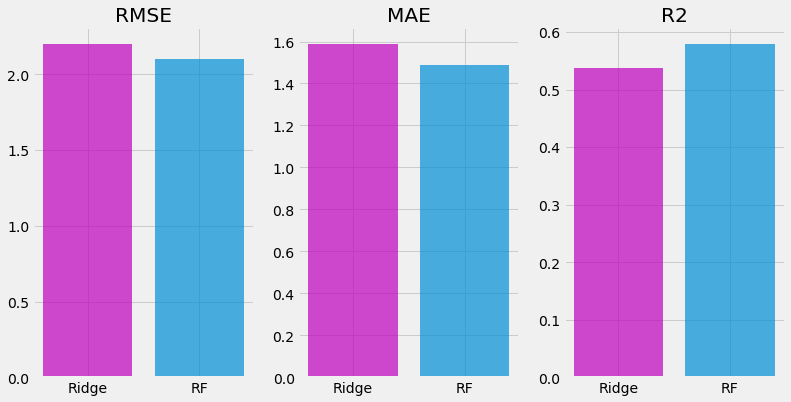

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 16
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(1,3, figsize=(12, 6))
for i, key in enumerate(best_rf_score.keys()):
  ax[i].bar(1, best_rf_score[key], alpha=0.7)
  ax[i].bar(0, best_ridge_score[key], color='m', alpha=0.7)
  ax[i].set_title(key)
  ax[i].set_xticks(np.arange(2))
  ax[i].set_xticklabels(labels=('Ridge', 'RF'))

Como vemos, se obtiene un menor error, y mayor coeficiente de determinación R2 para el modelo Random Forest. 

Las diferencias en los errores son pequeñas, rondando 0,1 años para ambas métricas, siendo más notoria la diferencia para el coeficiente de determinación.

A continuación, mostramos un *boxplot* a partir de las diferencias entre los valores predichos ($\hat{y}$) y el *ground truth* ($y$), y un *scatter plot* mapeando cada par de valores.

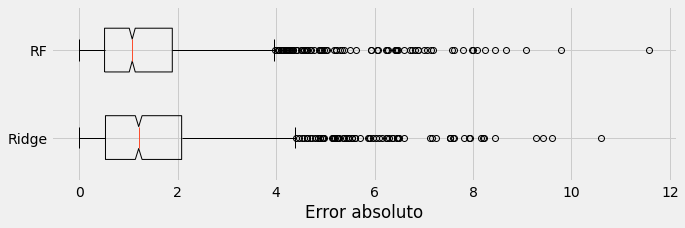

In [0]:
fig, ax = plt.subplots(figsize=(10,3))
ax.boxplot(np.transpose(pred_dif), notch=True, vert=False, widths=0.5)
ax.set_xlabel('Error absoluto')
ax.set_yticklabels(labels=('Ridge', 'RF'));

Tal como se observa con las métricas, se ve un menor error para el Random Forest. A pesar de que tiene el outlier más lejano, la media, cuartiles y el último bigote son menores.



Text(0.5, 0, '$y$ (Años)')

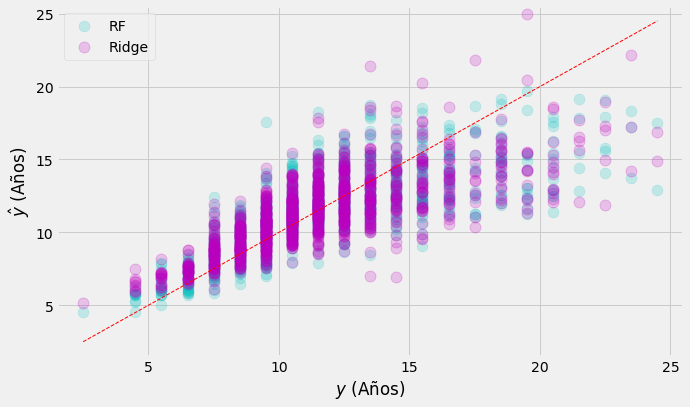

In [0]:
plt.scatter(y_test_st, y_test_hat_rf, label='RF', color='c', alpha=1/5, s=120)
plt.scatter(y_test_st, y_test_hat_ridge, label='Ridge', color='m', alpha=1/5, linewidths=1, s=120)
plt.plot([np.min(y_test_st), np.max(y_test_st)], [np.min(y_test_st), np.max(y_test_st)], '--', color='r', linewidth=1)
plt.xlim([np.min(y_test_st)-1, np.max(y_test_st)+1])
plt.ylim([np.min(y_test_st)-1, np.max(y_test_st)+1])
plt.legend()
plt.ylabel('$\hat{y}$ (Años)')
plt.xlabel('$y$ (Años)')

## 5.1 - Random Forest - Out-of-bag score

El modelo Random Forest permite obtener una medida del coeficiente de determinación, calculado a partir de los mismos datos de entrenamiento. Para esto, mide el error al predecir cierta instancia por un árbol que no fue entrenado con ella.

In [0]:
print('Out-of-bag score: ', best_rf.oob_score_)
print('R2 con los datos de entrenamiento: ', best_rf.score(X_train_st, y_train_st))
print('R2 con los datos de prueba: ', best_rf.score(X_test_st, y_test_st))

Out-of-bag score:  0.5486385126989524
R2 con los datos de entrenamiento:  0.8250914680968034
R2 con los datos de prueba:  0.5827029828962806


Con el Out-of-bag score obtenemos una medida más acertada del rendimiento del modelo con ejemplos nuevos.

## 5.2 - Random Forest - Feature importance

Otra ventaja que ofrece este modelo es la de calcular el *feature importance*, que permite determinar qué tan útil es un atributo para predecir la variable.

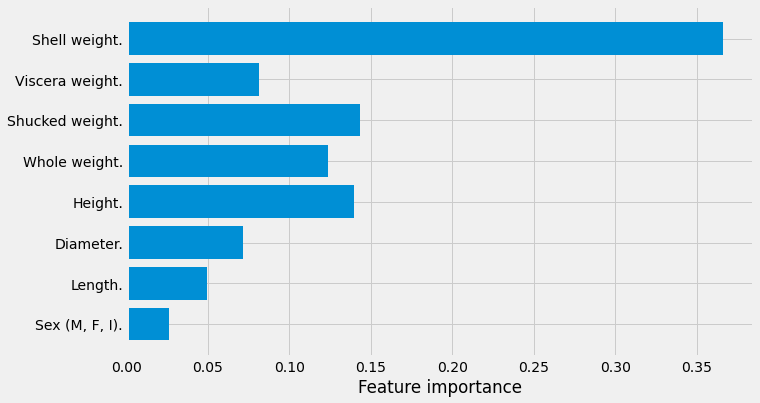

In [0]:
fig, ax = plt.subplots()
ax.barh(np.arange(8), best_rf.feature_importances_)
ax.set_xlabel('Feature importance')
ax.set_yticks(np.arange(8))
ax.set_yticklabels(labels=X_features.values());

El *Shell weight* es el atríbuto más relevante, con una importancia relativa de más del 35%, seguida por *Shucked weight* y *Height* de menos del 15% de importancia.

## 5.3 - Ridge - Coeficientes 

El Ridge Regressor calcula y devuelve los coeficientes para cada atríbuto, esto es, el peso relativo que tiene cada atributo al calcular la variable.

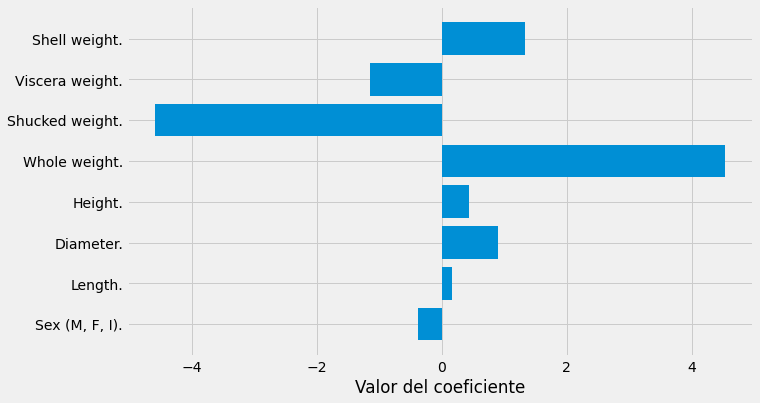

In [0]:
fig, ax = plt.subplots()
ax.barh(np.arange(8), best_ridge.coef_)
ax.set_xlabel('Valor del coeficiente')
ax.set_yticks(np.arange(8))
ax.set_yticklabels(labels=X_features.values());

En este modelo el *Shell weight* tiene un valor bajo, ocurriendo lo mismo para el *Height*. Sí se observa un mayor peso para *Shucked* y *Whole weight*, teniendo el primero de estos un coeficiente negativo.

Similar a lo que sucede con el Random Forest, los atributos *Length* y *Sex* no son relevantes para el modelo.

## 5.4 - Prueba con y sin estandarización

Tal como se explicó en el práctico previo no existen grandes variaciones en los rangos de representación numérica de los atributos. A pesar de esto, se aplica estandarización para llevar las medias de los atibutos a 0 y sus desvíos estándar a 1.

A continuación se vuelve a *fitear* al modelo de Random Forest, y se evalua sin eliminar los outliers y sin el proceso de estandarización.

In [0]:
print('Sin estandarización\n' + 5*'=' + '\n')
print(f'Valores máximos:  {np.max(X_test, axis=0)}')
print(f'Valores mínimos:  {np.min(X_test, axis=0)}')
print(f'Medias:           {np.mean(X_test, axis=0)}')
print(f'Desvíos estándar: {np.std(X_test, axis=0)}')

print('\nCon estandarización\n' + 5*'=' + '\n')
print(f'Valores máximos:  {np.max(X_test_st, axis=0)}')
print(f'Valores mínimos:  {np.min(X_test_st, axis=0)}')
print(f'Medias:           {np.mean(X_test_st, axis=0)}')
print(f'Desvíos estándar: {np.std(X_test_st, axis=0)}')

Sin estandarización
=====

Valores máximos:  [2.    0.815 0.65  0.25  2.78  1.351 0.76  1.005]
Valores mínimos:  [0.    0.075 0.055 0.    0.002 0.001 0.001 0.002]
Medias:           [0.981 0.517 0.402 0.137 0.804 0.349 0.176 0.231]
Desvíos estándar: [0.834 0.125 0.104 0.04  0.491 0.221 0.111 0.14 ]

Con estandarización
=====

Valores máximos:  [2.    2.447 2.469 2.571 3.963 4.445 5.299 5.499]
Valores mínimos:  [ 0.    -3.839 -3.659 -3.296 -1.71  -1.635 -1.672 -1.734]
Medias:           [ 0.981 -0.084 -0.081 -0.072 -0.071 -0.069 -0.063 -0.078]
Desvíos estándar: [0.834 1.063 1.069 0.935 1.003 0.997 1.018 1.009]


In [0]:
best_rf.fit(X_train, y_train)
y_test_hat = best_rf.predict(X_test)

best_rf_score_nost = {}

best_rf_score_nost['RMSE'] = mean_squared_error(y_test, y_test_hat, squared=False)
best_rf_score_nost['MAE'] = mean_absolute_error(y_test, y_test_hat)
best_rf_score_nost['R2'] = best_rf.score(X_test, y_test)

for key in best_rf_score:
  print(key + '\n' + 15*'=')
  print('Sin estandarizar : ', np.around(best_rf_score_nost[key], 4))
  print('Con estandarización : ', np.around(best_rf_score[key], 4))
  print('\n')

RMSE
Sin estandarizar :  2.0916
Con estandarización :  2.0911


MAE
Sin estandarizar :  1.4834
Con estandarización :  1.4825


R2
Sin estandarizar :  0.5825
Con estandarización :  0.5827




Como vemos, la diferencia es muy pequeña, a pesar de los cual el error es mayor para ambas métricas sin estandarización, siendo el coeficiente de determinación menor.

# 6 - Conclusiones

A partir de lo observado y explicado en este trabajo, se extraen las siguientes conclusiones:

* El modelo de Random Forest otorga un menor error, al evaluar tanto el *MAE* como el *RMSE*. Además, su coefiente de determinación **R2** es mayor. A pesar de esto, las diferencias en los errores no son sustanciales.
* Para el regresor Ridge, la calibración es importante, dado que el error es muy alto para mayor importancia del regularizador.
* Por otro lado, el proceso de *model selection* para Random Forest, no muestra grandes diferencias entre los parámetros utilizados. Es posible, a partir de lo realizado, ajustar y agregar nuevos parámetros, a modo de buscar un modelo con menor error.
* Cabe considerar que este último modelo demanda una mayor cantidad de tiempo de computo al utilizar `GridSearchCV()`, dada la cantidad de parámetros a configurar (en este ejemplo tenemos 4\*3\*4\*1 = 48 combinaciones de parámetros a computar). Una alternativa más rápida puede ser la de usar `RandomGridCV()` indicando menor cantidad de iteraciones.
* El proceso de estandarización mejora los resultados, a pesar de esto, las diferencias son muy pequeñas. De requerir menor procesamiento (o uno más rápido), puede trabajarse directamente sobre el dateset *raw*. 